## Imports

In [1]:
import pandas as pd
import os
import re
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import ttest_ind
from typing import Dict, Optional, Tuple

## Paths

In [2]:
SCORES = "/home/ge.polymtl.ca/p119912/data/nnunet_all/nnUNet_results/Dataset444_AGG/{}/scores/"
DATASETS = "/home/ge.polymtl.ca/p119912/data/nnunet_all/nnUNet_raw/"

## Functions

In [3]:
def make_results_table(data: Dict[str, pd.DataFrame]):
    """
    Aggregate the results into a single table
    
    Args:
        data (Dict[str, pd.DataFrame]): a dictionary of dataframes with the results 
        
    Returns:
        results (pd.DataFrame): a dataframe with the results
    """
    dfs = []
    for k in sorted(data.keys()):
        v = data[k]
        df = v.iloc[:,1:].groupby(['label', 'dataset']).mean()
        df.columns = pd.MultiIndex.from_product([[k], df.columns])
        dfs.append(df)
    results = pd.concat(dfs, axis=1).round(3)
    cols = results.columns.tolist()
    agg_cols = [col for col in cols if ('AGG' == col[0] or 'AGG_SYNTH' == col[0])]
    non_agg_cols = [col for col in cols if not ('AGG' == col[0] or 'AGG_SYNTH' == col[0])]
    new_col_order = non_agg_cols + agg_cols
    results = results[new_col_order]
    return results

def get_results(scores_path: str):
    """
    Get the results from the scores files
    
    Args:
        scores_path (str): the path to the scores files
    
    Returns:
        results (pd.DataFrame): a dataframe with the results
        results_modalities (pd.DataFrame): a dataframe with the results
        results_intra_bf (pd.DataFrame): a dataframe with the results
    """
    data = {}
    for d in os.listdir(scores_path):
        match = re.search(r'(.*)_model_best_checkpoints_scores.csv', d)
        try:
            dataset_name = match.group(1)
        except AttributeError:
            raise AttributeError("No match found")
        file_path = os.path.join(scores_path, d)
        df = pd.read_csv(file_path, index_col=0)
        if dataset_name == "wakehealth":
            dataset_name = "BF_wakehealth"
        data[dataset_name] = df.sort_values(by=['original_fname', 'label'])
        data[dataset_name]['dataset'] = data[dataset_name].index.to_series().apply(lambda x: '_'.join(x.split('_')[:-2]))
        data[dataset_name].loc[data[dataset_name]['dataset'] == "wakehealth", 'dataset'] = "BF_wakehealth"
        
    data_modality = deepcopy(data)
    for dataset in data_modality:
        data_modality[dataset].loc[data[dataset_name]['dataset'] == "BF_wakehealth", 'dataset'] = "BF"
        data_modality[dataset].loc[data[dataset_name]['dataset'] == "BF_RAT", 'dataset'] = "BF"
        data_modality[dataset].loc[data[dataset_name]['dataset'] == "BF_VCU", 'dataset'] = "BF"
        
    results = make_results_table(data)
    results_modalities = make_results_table(data_modality)

    results_modalities = results_modalities.loc[:, [col[0] in {"AGG_SYNTH", "AGG","BF_AGG","CARS","SEM","TEM"} for col in results_modalities.columns]]
    results_modalities.columns = pd.MultiIndex.from_tuples([("BF", col[1]) if col[0]=="BF_AGG" else tuple(col) for col in results_modalities.columns])

    results_intra_bf = results.iloc[['BF' in idx[1] for idx in results.index],['BF' in col[0] for col in results.columns]]
    results_intra_bf = results_intra_bf.iloc[:, [2*i+j for i in range(1,4) for j in range(2)]+[0,1]]   

    return results, results_modalities, results_intra_bf       

def plot_results(
    results: pd.DataFrame, 
    result_stds: Optional[pd.DataFrame]=None, 
    figsize: Tuple[int, int]=(18, 6), 
    vmax: float=1, 
    vmin: float=0, 
    size: int=10
    ):
    """
    Plot the results of the nnUNet experiments as a heatmap.
    
    Args:
        results (pd.DataFrame): a dataframe with the results
        result_stds (Optional[pd.DataFrame]): a dataframe with the standard deviations of the results
        figsize (Tuple[int, int]): the size of the figure
        vmax (float): the maximum value for the colormap
        vmin (float): the minimum value for the colormap
        size (int): the size of the annotation text
    """

    axon_dice = results.loc['axon'].xs('DiceMetric', level=1, axis=1)
    myelin_dice = results.loc['myelin'].xs('DiceMetric', level=1, axis=1)
    
    if result_stds is not None:
        axon_std = result_stds.loc['axon'].xs('DiceMetric', level=1, axis=1)
        myelin_std = result_stds.loc['myelin'].xs('DiceMetric', level=1, axis=1)

    # Set up the matplotlib figure
    f, axs = plt.subplots(1, 2, figsize=figsize)

    # Generate a custom diverging colormap for axon dice
    cmap_axon = sns.diverging_palette(250, 250, as_cmap=True)

    # Draw the heatmap for axon dice with the mask and correct aspect ratio
    if result_stds is not None:
        axon_annot = axon_dice.round(3).astype(str) + " ± " + axon_std.round(3).astype(str)
        annot_kws={"size": size}
    else:
        axon_annot = True
        annot_kws={}
    sns.heatmap(axon_dice, cmap=cmap_axon, vmax=vmax, vmin=vmin, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=axon_annot, fmt='', ax=axs[0], annot_kws=annot_kws)

    axs[0].set_title("Axon Dice Scores")
    axs[0].set_ylabel("Dataset")
    axs[0].set_xlabel("Model")

    # Generate a custom reddish colormap for myelin dice
    cmap_myelin = sns.diverging_palette(250, 15, as_cmap=True)

    # Draw the heatmap for myelin dice with the mask and correct aspect ratio
    if result_stds is not None:
        myelin_annot = myelin_dice.round(3).astype(str) + " ± " + myelin_std.round(3).astype(str)
        annot_kws={"size": size}  # Make the annotation text smaller
    else:
        myelin_annot = True  # Use default annotation (the data values)
        annot_kws={}  # No additional annotation keyword arguments
    sns.heatmap(myelin_dice, cmap=cmap_myelin, vmax=vmax, vmin=vmin, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=myelin_annot, fmt='', ax=axs[1], annot_kws=annot_kws)

    axs[1].set_title("Myelin Dice Scores")
    axs[1].set_ylabel("Dataset")
    axs[1].set_xlabel("Model")

    plt.show() 
    
def fold_violin_plot(dice_results_for_violin: pd.DataFrame, dice_results_ensemble_for_violin: pd.DataFrame):
    """
    This function creates a violin plot with the dice scores for the dedicated models and the ensemble models
    
    Args:
        dice_results_for_violin (pd.DataFrame): a dataframe with the dice scores for the dedicated models
        dice_results_ensemble_for_violin (pd.DataFrame): a dataframe with the dice scores for the ensemble models
    """
    # Your palette
    palette = {"myelin": "salmon", "axon": "deepskyblue"}
    palette_ensemble = {"ensemble myelin": "red", "ensemble axon": "blue"}

    # Create the violin plot with catplot
    g = sns.catplot(
        data=dice_results_for_violin, 
        x="source", 
        y="dice score", 
        hue="label", 
        col="dataset", 
        kind="violin", 
        inner="point", 
        sharey=False, 
        dodge=True, 
        aspect=0.5,
        palette=palette
    )

    # Remove the legend created by the first catplot
    g._legend.remove()

    # Iterate over each facet's axes to add the swarm plot
    for ax, (name, group) in zip(g.axes.flat, dice_results_ensemble_for_violin.groupby("dataset")):
        sns.swarmplot(
            data=group, 
            x="source", 
            y="dice score", 
            hue="label", 
            dodge=True, 
            palette=palette_ensemble,
            ax=ax,
            alpha=1, # Adjust for transparency
            marker="*",  # Use star-shaped markers
            s=11  
        )

    # This function adjusts the legend and other aesthetic parameters as needed
    def adjust_plots(g):
        # Remove the duplicate legends
        for ax in g.axes.flat:
            ax.legend_.remove()
        
        # Add a single legend for the whole figure
        handles, labels = ax.get_legend_handles_labels()
        g.fig.legend(handles=handles, labels=labels, loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1, frameon=False)#, title="Label")
        
        # Rotate xtick labels and adjust labels if necessary
        for ax in g.axes.flat:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.set_xlabel('')  # Clear the x-axis labels if desired
        
        # Adjust the layout
        plt.tight_layout()

    # Adjust plot after adding all layers
    adjust_plots(g)

    plt.show()
    
    
def get_dice_results(results: pd.DataFrame):
    """
    Get the dice results from the results dataframe
    
    Args:
        results (pd.DataFrame): a dataframe with the results
    
    Returns:
        dice_results (pd.DataFrame): a dataframe with the dice results
    """
    datasets = ("BF","CARS", "SEM", "TEM")
    dice_results = []
    for data in datasets:
        # Get the results for the dedicated models
        dedicated = results.loc[
            [dataset == data for _, dataset in results.index], 
            [col[0] in {data, "AGG", "AGG_SYNTH", "fold"} for col in results.columns]
        ].copy()
        # Rename the columns to rename the dedicated models to "dedicated""
        dedicated.columns = pd.MultiIndex.from_tuples([("dedicated", col[1]) if col[0] == data else tuple(col) for col in dedicated.columns])
        dice_results.append(dedicated)

    # Concatenate the results and reset the index
    dice_results = pd.concat(dice_results, axis=0).reset_index()

    # Only keep the columns that are not the mean IoU (Dice scores and structure and dataset names)
    dice_results = dice_results.loc[:, [col[1] != "MeanIoU" for col in dice_results.columns]]
    dice_results.columns = [col[0] for col in dice_results.columns]
    dice_results = dice_results.reset_index() 
    return dice_results                 


## Analysis

In [4]:
# Get the results for the ensemble of folds of the models
results_ensemble, results_modalities_ensemble, results_intra_bf_ensemble = get_results(SCORES.format("ensemble_models"))

# Get the results for the individual folds of the models
results_folds_all = [get_results(SCORES.format(f"fold_{{{i}}}")) for i in range(5)]
results_folds = pd.concat([results.assign(fold=i) for i, (results, _, _) in enumerate(results_folds_all)], axis=0)
results_modalities_folds = pd.concat([results.assign(fold=i) for i, (_, results, _) in enumerate(results_folds_all)], axis=0)
results_intra_bf_folds = pd.concat([results.assign(fold=i) for i, (_, _, results) in enumerate(results_folds_all)], axis=0)

### Heatmaps

#### All Datasets

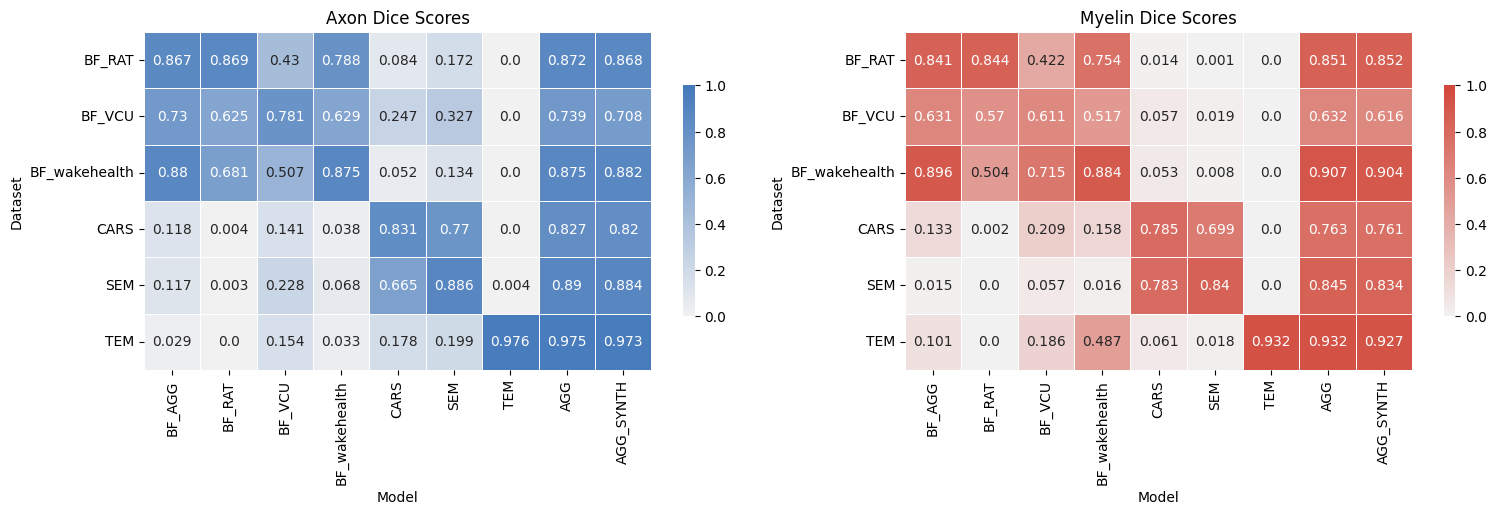

In [5]:
plot_results(results_ensemble, figsize=(18, 6))

#### Intermodality

Intermodality results for the ensemble of models with the synthetic data


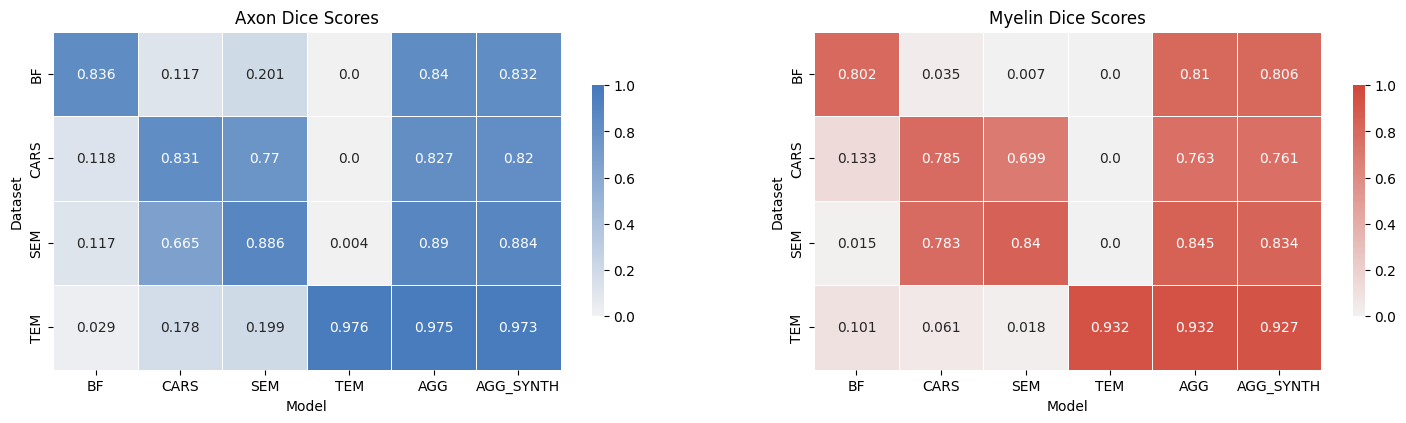

Intermodality results for the ensemble of models without the synthetic data


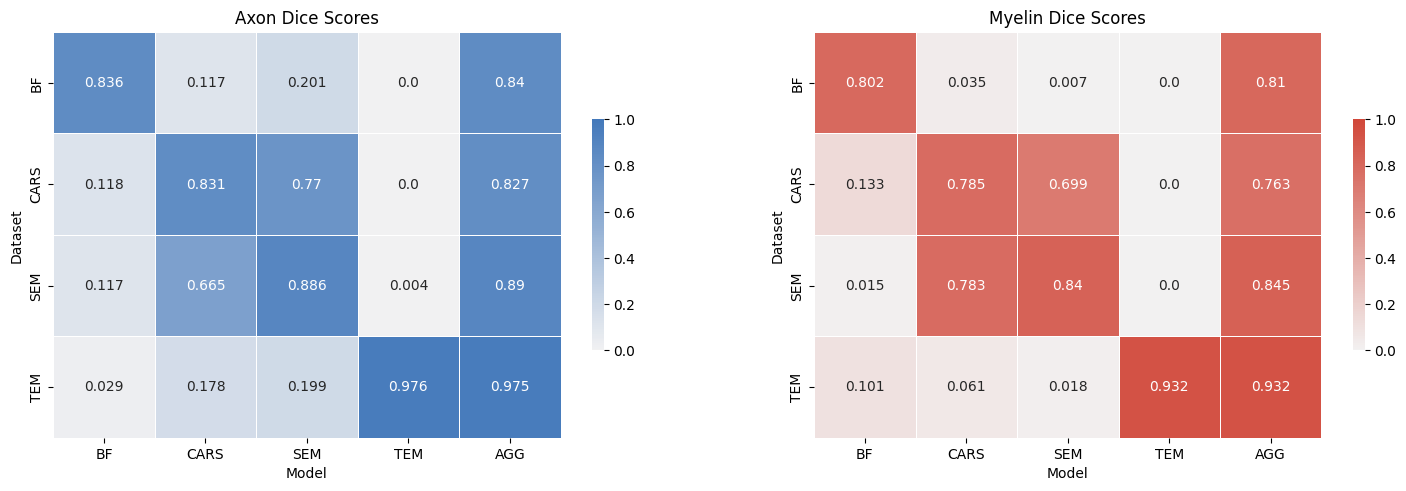

Intermodality results of individual folds without the synthetic data


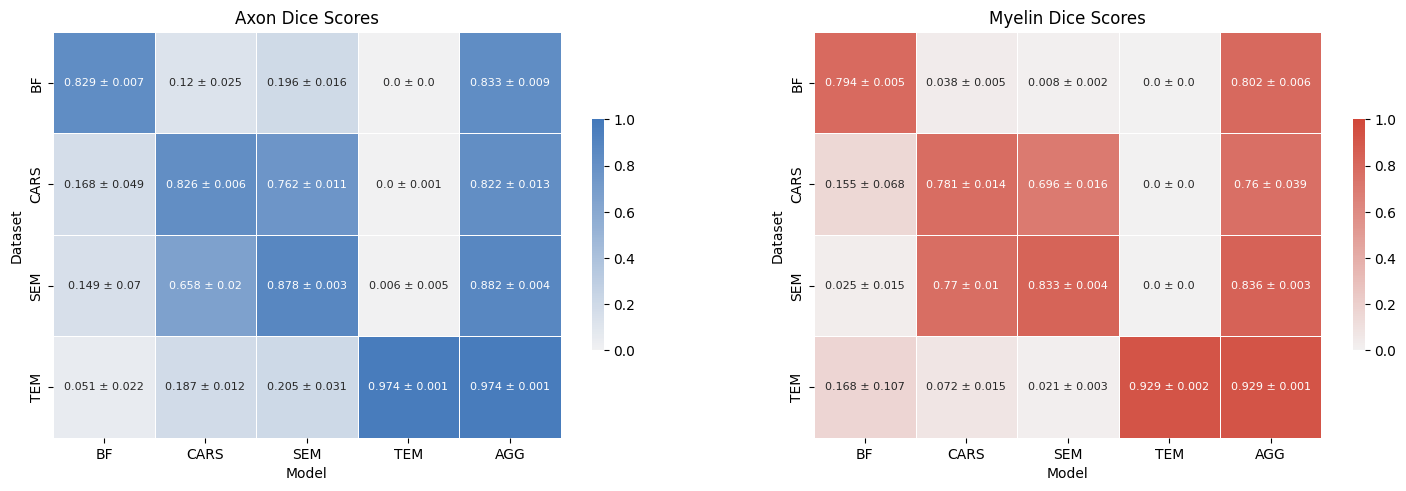

In [6]:
print("Intermodality results for the ensemble of models with the synthetic data")
plot_results(results_modalities_ensemble, figsize=(18, 6))

print("Intermodality results for the ensemble of models without the synthetic data")
plot_results(results_modalities_ensemble.iloc[:, :-2], figsize=(18, 6))

print("Intermodality results of individual folds without the synthetic data")
plot_results(
    results_modalities_folds.groupby(["label", "dataset"]).mean().round(3).iloc[:, :-3],
    results_modalities_folds.groupby(["label", "dataset"]).std().round(3).iloc[:, :-3], 
    figsize=(18, 6), 
    size=8
)


#### Intramodality (BF datasets)

Intramodality esults of ensemble models on the BF dataset


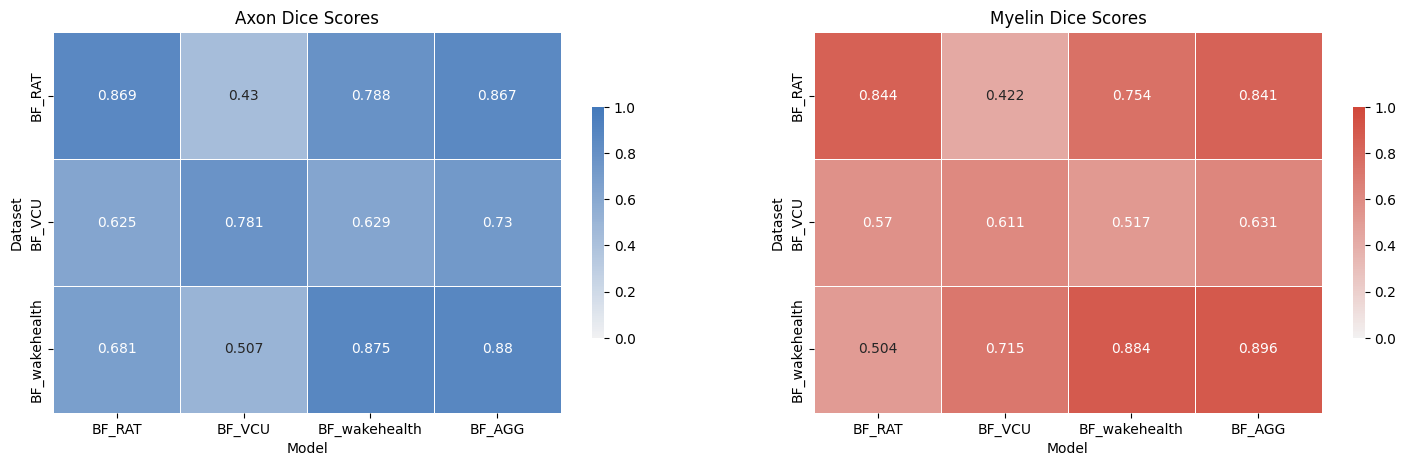

Intramodality results of individual folds on the BF dataset


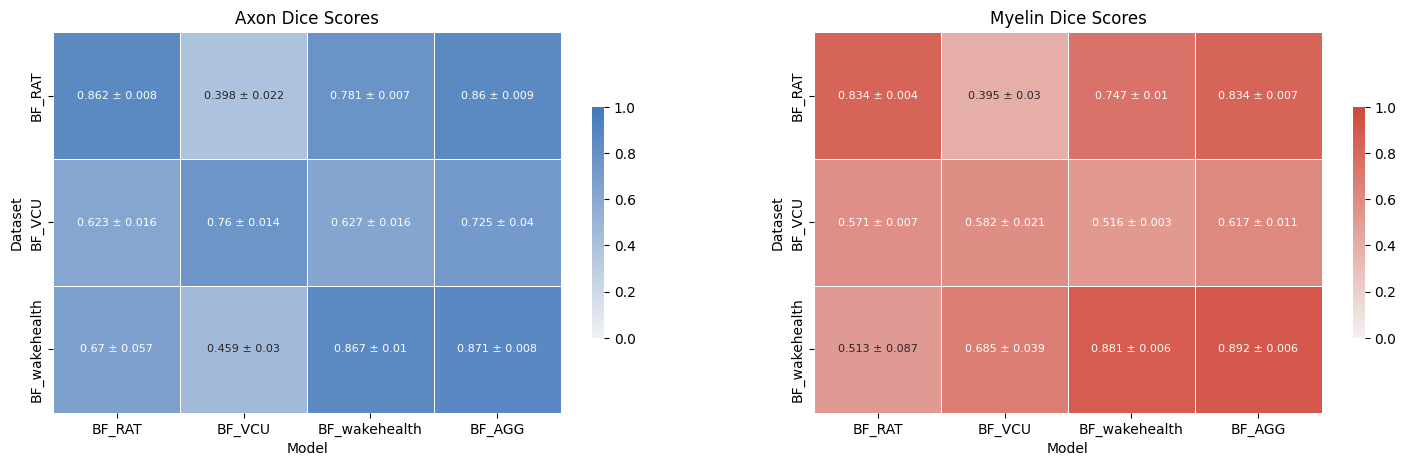

In [7]:
print("Intramodality esults of ensemble models on the BF dataset")
plot_results(results_intra_bf_ensemble, figsize=(18, 6), vmin=0)

print("Intramodality results of individual folds on the BF dataset")
plot_results(
    results_intra_bf_folds.groupby(["label", "dataset"]).mean().round(3),
    results_intra_bf_folds.groupby(["label", "dataset"]).std().round(3), 
    figsize=(18, 6), 
    size=8
)

### Statistical Analysis

In [8]:
results_modalities_folds.head(10)

BF               CARS                SEM          \
               DiceMetric MeanIoU DiceMetric MeanIoU DiceMetric MeanIoU   
label  dataset                                                            
axon   BF           0.832   0.716      0.161   0.090      0.221   0.128   
       CARS         0.169   0.092      0.825   0.703      0.766   0.621   
       SEM          0.173   0.095      0.692   0.537      0.883   0.795   
       TEM          0.035   0.018      0.206   0.115      0.210   0.117   
myelin BF           0.797   0.674      0.032   0.016      0.011   0.005   
       CARS         0.107   0.057      0.761   0.615      0.704   0.543   
       SEM          0.006   0.003      0.782   0.647      0.837   0.725   
       TEM          0.125   0.067      0.048   0.025      0.024   0.012   
axon   BF           0.820   0.705      0.111   0.061      0.199   0.113   
       CARS         0.094   0.049      0.818   0.692      0.775   0.632   

                      TEM                AGG          AGG_SYNTH         fold  
               DiceMetric MeanIoU DiceMetric MeanIoU DiceMetric MeanIoU       
label  dataset                                                                
axon   BF           0.000   0.000      0.821   0.700      0.826   0.711    0  
       CARS         0.002   0.001      0.830   0.710      0.822   0.697    0  
       SEM          0.005   0.003      0.884   0.797      0.873   0.781    0  
       TEM          0.975   0.951      0.974   0.950      0.974   0.949    0  
myelin BF           0.000   0.000      0.799   0.679      0.802   0.683    0  
       CARS         0.001   0.000      0.791   0.654      0.777   0.635    0  
       SEM          0.000   0.000      0.837   0.725      0.824   0.706    0  
       TEM          0.930   0.870      0.929   0.867      0.926   0.862    0  
axon   BF           0.000   0.000      0.846   0.737      0.835   0.722    1  
       CARS         0.000   0.000      0.830   0.709      0.819   0.693    1

In [9]:
dice_results = get_dice_results(results_modalities_folds)
dice_results.head()

,index,label,dataset,dedicated,AGG,AGG_SYNTH,fold
0,0,axon,BF,0.832,0.821,0.826,0
1,1,myelin,BF,0.797,0.799,0.802,0
2,2,axon,BF,0.820,0.846,0.835,1
3,3,myelin,BF,0.791,0.811,0.805,1
4,4,axon,BF,0.835,0.834,0.829,2


#### Two One-Sided Tests (TOST)

In this section, we conduct a statistical analysis to compare the performance of AGG models with that of dedicated models, utilizing the Two One-Sided Tests (TOST) for equivalence. The structure of the analysis is as follows:
- The TOST procedure is applied to determine if the performance differences between the AGG models and the dedicated models are statistically equivalent within a predefined margin.
- The null hypothesis $H_0$ posits that the mean performance difference between the dedicated model $\mu_{\text{dedicated}}$ and the AGG model $\mu_{\text{AGG}}$ is outside the bounds of equivalence: $H_0: |\mu_{\text{dedicated}} - \mu_{\text{AGG}}| \geq \delta$.
- The alternative hypothesis $H_1$ suggests that the mean performance difference is within the bounds of equivalence, indicating no significant difference between the models: $H_1: |\mu_{\text{dedicated}} - \mu_{\text{AGG}}| < \delta$.
- This analysis aims to provide insights into whether the performances of dedicated models and AGG models are statistically equivalent, thereby assessing the practical significance of choosing one model type over the other under various conditions.




In [10]:
import statsmodels.stats.weightstats as smws

# Define the structures of interest
structures = ("axon", "myelin")

# Define the datasets of interest
datasets = ("BF","CARS", "SEM", "TEM")

# define the number of tests
n_tests = len(structures) * len(datasets)

# Set the significance level
alpha = 0.05

# Adjust the significance level for multiple comparisons (Sidak correction)
alpha_adjusted = 1 - (1- alpha)**(1/n_tests)
print(f"Given the number of tests ({n_tests}) and the significance level ({alpha}), the adjusted significance level is {alpha_adjusted}\n\n")

# Define the equivalence margin (delta)
# This margin is the maximum acceptable difference between the groups for them to be considered equivalent
delta = 0.02

tost_tests = []
for structure in ("axon", "myelin"):
    for dataset in datasets:
        # extract the data for the structure ("myelin" or "axon") and dataset ("BF","CARS", "SEM", "TEM")
        data = dice_results.loc[(dice_results["label"] == structure) & (dice_results["dataset"] == dataset), :]
        
        # Perform the Two One-Sided Tests (TOST) for equivalence
        tost_pvalue = smws.ttost_ind(data["dedicated"], data["AGG"], low=-delta, upp=delta)

        # Interpret the results
        print(f"TOST p-value: {tost_pvalue[0]}")
        if tost_pvalue[0] < alpha_adjusted:
            significance = True
            print(f"{structure}, {dataset} => The test provides evidence that the means of the two groups are equivalent within the specified margin.")
        else:
            significance = False
            print(f"{structure}, {dataset} => The test does not provide evidence that the means of the two groups are equivalent within the specified margin.")
        
        tost_tests.append((structure, dataset, tost_pvalue[0], significance))
        

p_values = pd.DataFrame(tost_tests, columns=["structure", "dataset", "p-value", "significant"])
p_values


Given the number of tests (8) and the significance level (0.05), the adjusted significance level is 0.006391150954545011


TOST p-value: 0.005710151711949052
axon, BF => The test provides evidence that the means of the two groups are equivalent within the specified margin.
TOST p-value: 0.017538064055311466
axon, CARS => The test does not provide evidence that the means of the two groups are equivalent within the specified margin.
TOST p-value: 8.684530851614389e-05
axon, SEM => The test provides evidence that the means of the two groups are equivalent within the specified margin.
TOST p-value: 1.152365074553743e-10
axon, TEM => The test provides evidence that the means of the two groups are equivalent within the specified margin.
TOST p-value: 0.003631215549707574
myelin, BF => The test provides evidence that the means of the two groups are equivalent within the specified margin.
TOST p-value: 0.5253895478868432
myelin, CARS => The test does not provide evidence that the means of the 

,structure,dataset,p-value,significant
0,axon,BF,5.710152e-03,True
1,axon,CARS,1.753806e-02,False
2,axon,SEM,8.684531e-05,True
3,axon,TEM,1.152365e-10,True
4,myelin,BF,3.631216e-03,True
5,myelin,CARS,5.253895e-01,False
6,myelin,SEM,2.899160e-05,True
7,myelin,TEM,7.192634e-08,True


#### Violin plots

In [11]:
dice_results_ensemble = get_dice_results(results_modalities_ensemble)
dice_results_ensemble_for_violin = dice_results_ensemble.melt(id_vars=["label", "dataset"], value_vars=["dedicated", "AGG", "AGG_SYNTH"], var_name="source", value_name="dice score")
dice_results_ensemble_for_violin["label"] = dice_results_ensemble_for_violin["label"].apply(lambda x: "ensemble " + x)
dice_results_ensemble_for_violin.head()

,label,dataset,source,dice score
0,ensemble axon,BF,dedicated,0.836
1,ensemble myelin,BF,dedicated,0.802
2,ensemble axon,CARS,dedicated,0.831
3,ensemble myelin,CARS,dedicated,0.785
4,ensemble axon,SEM,dedicated,0.886


In [12]:
dice_results_for_violin = dice_results.melt(id_vars=["label", "dataset", "fold"], value_vars=["dedicated", "AGG", "AGG_SYNTH"], var_name="source", value_name="dice score")
dice_results_for_violin.head()

,label,dataset,fold,source,dice score
0,axon,BF,0,dedicated,0.832
1,myelin,BF,0,dedicated,0.797
2,axon,BF,1,dedicated,0.820
3,myelin,BF,1,dedicated,0.791
4,axon,BF,2,dedicated,0.835


/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


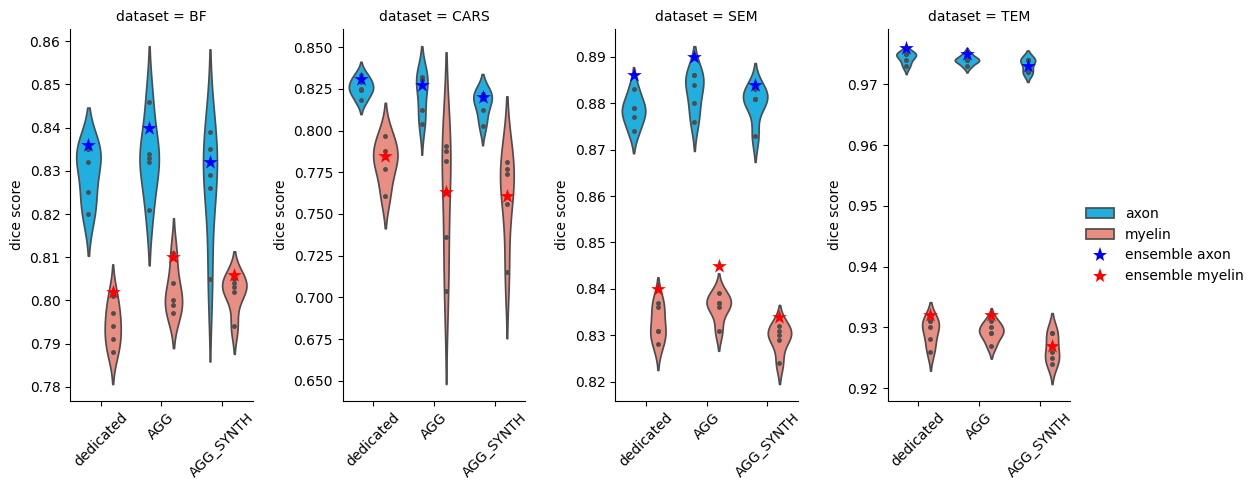

In [13]:
fold_violin_plot(dice_results_for_violin, dice_results_ensemble_for_violin)

/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3487002/1804701172.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


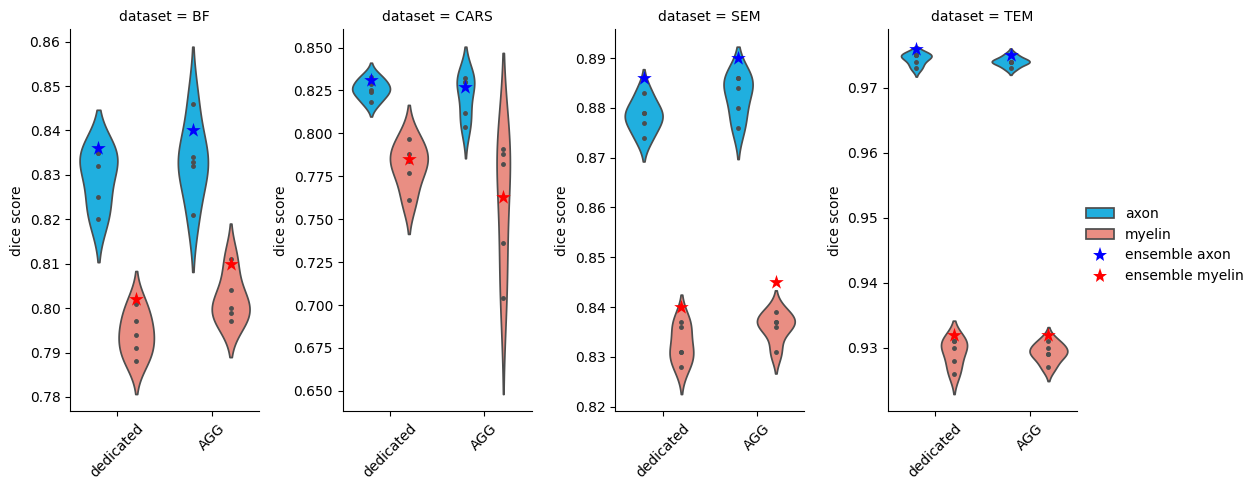

In [15]:
fold_violin_plot(
    dice_results_for_violin.loc[dice_results_for_violin["source"] != "AGG_SYNTH"], 
    dice_results_ensemble_for_violin.loc[dice_results_ensemble_for_violin["source"] != "AGG_SYNTH"]
    )